# More on Data Manipulation and Analysis Frameworks

## Dependencies

In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
# don't forget to always enter your virtualenv environment and to rerun pip install -r requirements.txt to get the latest deps
import pandas_datareader.data as web
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from datetime import datetime

%matplotlib inline

## Filtering rows in a DataFrame

In [2]:
stocks = 'YELP'
data_source = 'robinhood'
df = web.DataReader(stocks, data_source)
df.to_csv('rh_data.csv')
df = pd.read_csv('rh_data.csv')

It is relatively straightforward to select rows of interest from the data set. Note that all of the operations below return a new DataFrame, which can be treated the same way as all DataFrames we have seen so far.

In [3]:
tmp_high = df['high_price'] > 49 # Overloaded comparison operator.
tmp_high.head()

0    False
1    False
2    False
3    False
4    False
Name: high_price, dtype: bool

Taking the sum of an array of `bool` values is the same as counting the number of `True` values in the array.

In [4]:
sum(tmp_high)

3

We can select only the rows of `df` that correspond to `tmp_high`.

In [5]:
df[tmp_high]

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume
227,YELP,2018-08-09,48.33,49.7651,False,43.5100,44.00,reg,26302215
228,YELP,2018-08-10,49.35,51.3300,False,47.5400,48.03,reg,9312655
229,YELP,2018-08-13,46.94,49.5700,False,46.8646,49.56,reg,4490863


Putting it all together, we have the following commonly-used patterns.

In [6]:
positive_days = df[df['close_price'] > df['open_price']]
positive_days.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume
0,YELP,2017-09-14,42.91,43.03,False,42.5200,42.75,reg,1190931
1,YELP,2017-09-15,43.57,43.70,False,42.7600,42.91,reg,4243413
3,YELP,2017-09-19,43.85,44.07,False,43.0401,43.50,reg,859142
4,YELP,2017-09-20,44.17,44.24,False,43.4400,43.78,reg,940095
9,YELP,2017-09-27,42.70,42.79,False,41.8000,42.09,reg,1471632


In [7]:
very_positive_days = df[df['close_price'] - df['open_price'] > 4]
very_positive_days.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume
227,YELP,2018-08-09,48.33,49.7651,False,43.51,44.0,reg,26302215


Note that conditions can also be combined by taking the conjunction or disjunction of the data frames used as conditions. Note the use of the intersection operator. This is primarily because the built-in Python `and` and `or` operators cannot be overloaded.

In [8]:
(df['close_price'] > 43) & (df['open_price'] < 43)

0      False
1       True
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11      True
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
222    False
223    False
224    False
225    False
226    False
227    False
228    False
229    False
230    False
231    False
232    False
233    False
234    False
235    False
236    False
237    False
238    False
239    False
240    False
241    False
242    False
243    False
244    False
245    False
246    False
247    False
248    False
249    False
250    False
251    False
Length: 252, dtype: bool

In [9]:
very_positive_days = df[(df['close_price'] > 43) & (df['open_price'] < 43)]
very_positive_days.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume
1,YELP,2017-09-15,43.57,43.70,False,42.76,42.91,reg,4243413
11,YELP,2017-09-29,43.30,43.42,False,42.59,42.62,reg,898853
75,YELP,2018-01-02,43.24,43.47,False,42.06,42.06,reg,1355264
78,YELP,2018-01-05,43.17,43.34,False,42.74,42.95,reg,916723
88,YELP,2018-01-22,43.40,43.49,False,42.02,42.70,reg,975227


## Creating new columns in a DataFrame

To create a new column, assign a DataFrame to it. This behavior is similar to that of Python dictionaries.

In [10]:
df['profit'] = (df['open_price'] < df['close_price'])
df.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume,profit
0,YELP,2017-09-14,42.91,43.03,False,42.5200,42.75,reg,1190931,True
1,YELP,2017-09-15,43.57,43.70,False,42.7600,42.91,reg,4243413,True
2,YELP,2017-09-18,43.50,44.23,False,43.3500,43.80,reg,1261139,False
3,YELP,2017-09-19,43.85,44.07,False,43.0401,43.50,reg,859142,True
4,YELP,2017-09-20,44.17,44.24,False,43.4400,43.78,reg,940095,True


In the code below, we create a new discrete feature dimension within the data frame that places every row into one of four possible `gain` categories.

In [11]:
for idx, row in df.iterrows():
    if row.close_price > row.open_price:
        df.loc[idx,'gain']='negative'
    elif (row.open_price - row.close_price) < 1:
        df.loc[idx,'gain']='small_gain'
    elif (row.open_price - row.close_price) < 6:
        df.loc[idx,'gain']='medium_gain'
    else:
        df.loc[idx,'gain']='large_gain'

df.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume,profit,gain
0,YELP,2017-09-14,42.91,43.03,False,42.5200,42.75,reg,1190931,True,negative
1,YELP,2017-09-15,43.57,43.70,False,42.7600,42.91,reg,4243413,True,negative
2,YELP,2017-09-18,43.50,44.23,False,43.3500,43.80,reg,1261139,False,small_gain
3,YELP,2017-09-19,43.85,44.07,False,43.0401,43.50,reg,859142,True,negative
4,YELP,2017-09-20,44.17,44.24,False,43.4400,43.78,reg,940095,True,negative


Below is a more functional way to accomplish the same thing by defining a function that classifies rows, and then using `apply` to transform all the rows. The `axis=1` parameter indicates that it should be applied to each row (a parameter of `axis=0` would indicate that the function should be applied to each column).

In [12]:
def namerow(row):
    if row.close_price > row.open_price:
        return 'negative'
    elif (row.open_price - row.close_price) < 1:
        return 'small_gain'
    elif (row.open_price - row.close_price) < 6:
        return 'medium_gain'
    else:
        return 'large_gain'

df['test_column'] = df.apply(namerow, axis=1)
df.head()


,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume,profit,gain,test_column
0,YELP,2017-09-14,42.91,43.03,False,42.5200,42.75,reg,1190931,True,negative,negative
1,YELP,2017-09-15,43.57,43.70,False,42.7600,42.91,reg,4243413,True,negative,negative
2,YELP,2017-09-18,43.50,44.23,False,43.3500,43.80,reg,1261139,False,small_gain,small_gain
3,YELP,2017-09-19,43.85,44.07,False,43.0401,43.50,reg,859142,True,negative,negative
4,YELP,2017-09-20,44.17,44.24,False,43.4400,43.78,reg,940095,True,negative,negative


We can remove a column using the `.drop()` method.

In [13]:
df.drop('test_column', axis = 1)
df.head()

,symbol,begins_at,close_price,high_price,interpolated,low_price,open_price,session,volume,profit,gain,test_column
0,YELP,2017-09-14,42.91,43.03,False,42.5200,42.75,reg,1190931,True,negative,negative
1,YELP,2017-09-15,43.57,43.70,False,42.7600,42.91,reg,4243413,True,negative,negative
2,YELP,2017-09-18,43.50,44.23,False,43.3500,43.80,reg,1261139,False,small_gain,small_gain
3,YELP,2017-09-19,43.85,44.07,False,43.0401,43.50,reg,859142,True,negative,negative
4,YELP,2017-09-20,44.17,44.24,False,43.4400,43.78,reg,940095,True,negative,negative


## Grouping

A useful DataFrame method is `groupby()`. It is analagous to the `GROUP BY` query construct in SQL. It groups rows of a DataFrame by the values in one (or more) columns, and makes it possible to iterate through each group. 

Here we will look at the average gain among the  categories of gains (`negative`, `small`, `medium` and `large`) that we defined above and stored in column `gain`.

In [14]:
gain_groups = df.groupby('gain')

In [15]:
gain_groups

The `gain_groups` data structures behaves like a dictionary where:
* the keys are the unique values found in the `gain` column, and
* the values are **data frames** that contain only the rows having the corresponding unique values.

In [16]:
for gain, gain_data in gain_groups:
    print(gain)
    print(gain_data.head())
    print('=============================')

medium_gain
   symbol   begins_at  close_price  high_price  interpolated  low_price  \
7    YELP  2017-09-25        41.90     43.1299         False      41.32   
18   YELP  2017-10-10        44.40     45.8200         False      43.90   
34   YELP  2017-11-01        46.03     48.1700         False      45.95   
53   YELP  2017-11-29        45.20     47.7500         False      45.00   
56   YELP  2017-12-04        43.05     44.3200         False      42.37   

    open_price session   volume  profit         gain  test_column  
7        43.03     reg  2026892   False  medium_gain  medium_gain  
18       45.55     reg  1898232   False  medium_gain  medium_gain  
34       47.22     reg  3919774   False  medium_gain  medium_gain  
53       47.35     reg  1469804   False  medium_gain  medium_gain  
56       44.10     reg  1194377   False  medium_gain  medium_gain  
negative
  symbol   begins_at  close_price  high_price  interpolated  low_price  \
0   YELP  2017-09-14        42.91       43.03 

In [17]:
for gain, gain_data in df.groupby("gain"):
    print('The average closing value for the {} group is {}'.format(gain,
                                                           gain_data['close_price'].mean()))

The average closing value for the medium_gain group is 42.66521739130434
The average closing value for the negative group is 43.876612903225805
The average closing value for the small_gain group is 43.143047619047614


Note that another way to view a DataFrame is as an annotated two-dimensional array. The pandas library also has annotated versions of one-dimensional arrays (each of these is called a **`Series`**) and three-dimensional arrays (each of these is called a **`Panel`**).

## Example: comparing multiple stocks

We will use the techniques we have learned so far -- together with some new ones -- in order to compare the performance of different stocks.

In [18]:
stocks = ['ORCL', 'TSLA', 'IBM', 'YELP', 'MSFT']
attr = 'close_price'
df = web.DataReader(stocks, data_source)
df = df[attr]
df.head()

symbol  begins_at 
ORCL    2017-09-14    51.958800
        2017-09-15    47.972600
        2017-09-18    47.569100
        2017-09-19    47.283600
        2017-09-20    47.214700
Name: close_price, dtype: object

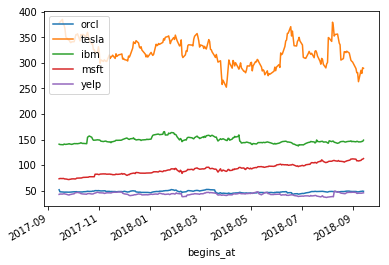

In [19]:
df.ORCL.astype(float).plot(label = 'orcl')
df.TSLA.astype(float).plot(label = 'tesla')
df.IBM.astype(float).plot(label = 'ibm')
df.MSFT.astype(float).plot(label = 'msft')
df.YELP.astype(float).plot(label = 'yelp')
_ = plt.legend(loc='best')

We will calculate returns $r(T)$ over a period of length $T$, defined as:

$$r(t) = \frac{f(t)-f(t-T)}{f(t-T)}$$

The returns can be computed with a DataFrame method `pct_change()`.  Note that for the first $T$ timesteps, this value is not defined.

In [20]:
rets = df.astype(float).pct_change(30)
rets.head()

symbol  begins_at 
ORCL    2017-09-14   NaN
        2017-09-15   NaN
        2017-09-18   NaN
        2017-09-19   NaN
        2017-09-20   NaN
Name: close_price, dtype: float64

We could also compute any given row of the table directly using the formula. For example, we do so below for row `30` with $T = 30$.

In [21]:
(df.astype(float).iloc[30] - df.astype(float).iloc[0])/df.astype(float).iloc[0]

-0.0462616534638982

We can plot the time series of the returns of the different stocks. Notice that the `NaN` values are gracefully dropped by the plotting function.

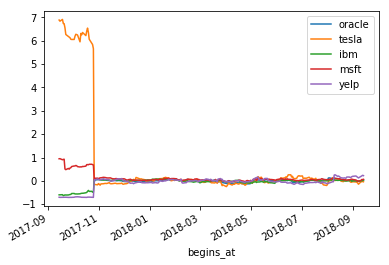

In [22]:
rets.ORCL.plot(label = 'oracle')
rets.TSLA.plot(label = 'tesla')
rets.IBM.plot(label = 'ibm')
rets.MSFT.plot(label = 'msft')
rets.YELP.plot(label = 'yelp')
plt.legend(loc='best')

We can compare the returns from two stocks by creating a scatter plot.

Text(0,0.5,'ORCL 30-day returns')

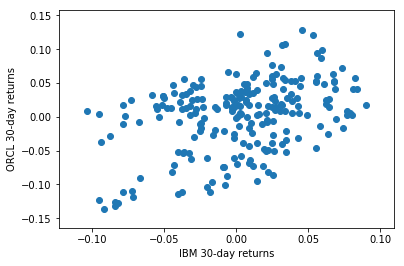

In [23]:
plt.scatter(rets.IBM, rets.ORCL)
plt.xlabel('IBM 30-day returns')
plt.ylabel('ORCL 30-day returns')

There appears to be some correlation between the movement of IBM and ORCL stocks. We can try to quantify this. The pandas library provides a DataFrame method to compute the correlation coefficient of all pairs of columns: `corr()`.

In [24]:
rets = rets.unstack(level=0)
rets.corr()

symbol,IBM,MSFT,ORCL,TSLA,YELP
symbol,,,,,
IBM,1.000000,-0.916237,0.406079,-0.968995,0.919567
MSFT,-0.916237,1.000000,0.732001,0.966541,-0.887608
ORCL,0.406079,0.732001,1.000000,0.276537,0.307667
TSLA,-0.968995,0.966541,0.276537,1.000000,-0.942857
YELP,0.919567,-0.887608,0.307667,-0.942857,1.000000


It takes a bit of time to examine that table and draw conclusions. To speed that process up it helps to visualize the table. We will learn more about visualization later, but for now this is a simple example.

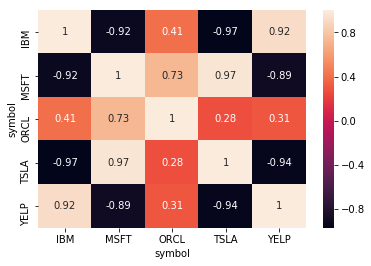

In [25]:
_ = sns.heatmap(rets.corr(), annot=True)

Finally, it is important to know that the plotting performed by pandas is just a layer on top of `matplotlib` (i.e., the `plt` package). So these plots can be improved by using additional functions from `matplotlib`.

For example, suppose we want to know both the returns as well as the standard deviation of the returns of a stock (i.e., its risk). Here is visualization of the result of such an analysis, and we construct the plot using only functions from `matplotlib`.

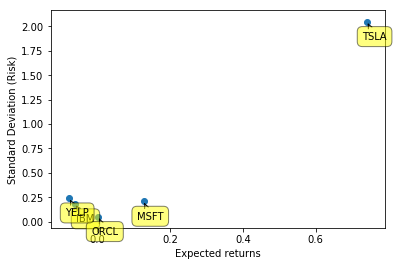

In [26]:
plt.xlabel('Expected returns')
plt.ylabel('Standard Deviation (Risk)')
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
_ = plt.scatter(rets.mean(), rets.std())

To understand what these functions are doing, (especially the `annotate` function), you can consult the online documentation for matplotlib.